# Read raw data of T2,T2F,TR and T3 -> smooth

In [23]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Smooth data

In [24]:
#Smooth data from raw files
# we can only smooth data for parameters where we have more than one value and it varies drastically across
# a) multiple tries on the same run (this happens only with T2F and TR as they are in a loop the robot can retry multiple times)
# b) multiple runs
#where a run is the robot moving from s0 to an end state

#
def get_full_path(folder_path, filename):
    return os.path.join(folder_path, filename)

def clean_file(output_file):
    with open(output_file, "w") as output_file:
        pass
    
def winsorize(df,n_std=2,ignore=-1): #n_std: -1= mean, 1,2,3=standar deviations
    # Step 1: Ignore values that are -1
    filtered_df = df[df != -1]
    
    # Step 2: Calculate mean and standard deviation of the remaining values
    mean = filtered_df.stack().mean()
    std_dev = filtered_df.stack().std()
    
    # Step 3: Replace values outside 2 standard deviations with the mean +- n standard deviations
    df2 = df.copy()
    for index, row in df2.iterrows():
        for column, value in row.iteritems():
            if value!=-1:
                
                if(n_std<0):
                    if value> (mean + n_std*-1 * std_dev):
                        df2.loc[index, column] = mean
                    elif value< (mean - n_std*-1 * std_dev):
                        df2.loc[index, column] = mean
                else:
                    if value> (mean + n_std * std_dev):
                        df2.loc[index, column] = mean + n_std * std_dev
                    elif value< (mean - n_std * std_dev):
                        df2.loc[index, column] = mean - n_std * std_dev
    return df2


#outside n standar deviations smooth value by change it to mean +- n*std


def get_smooth(full_path,full_path_output,col="T2,T2F,TR,T3",n_std=2,verbose="true"):
    df = pd.read_csv(full_path)
    dforiginal = df.copy()
    
    col = col.split(",")
    
    for c in col:
        #1 get only columns matching name
        if c=="T2F" or c=="TR": #get all columns
            df_smooth = df.loc[:, df.columns.str.startswith(c)]
        else:
            df_smooth = pd.DataFrame(df[c])
            
        #2 smooth data
        df_smooth = winsorize(df_smooth,n_std,ignore=-1)
    
        #3 replace columns in df with columns from df_smooth if they have the same names
        for column_name in df_smooth.columns:
            df[column_name] = df_smooth[column_name]
        
    #save new df
    df.to_csv(full_path_output, index=False)
    #print one sample
    if "outcome_0.5_0.3_0.5" in full_path_output and verbose=="true":
        print(full_path,dforiginal)
        print(full_path_output,df)
        
        
def smoothRawData(folder_path,col=["T2,T2F,TR,T3"],n_std=2,verbose="true"):
    for filename in os.listdir(folder_path):
        full_path = get_full_path(folder_path, filename)
        if os.path.isfile(full_path) and (filename.split("_")[0]=="outcome"):
            
            full_path_output = get_full_path(folder_path, "smooth"+filename)
            clean_file(full_path_output)

            #print(f"File: {filename}")
            get_smooth(full_path,full_path_output,col,n_std,verbose)
            
    print("New smooth .csv file saved")

### Show smooth data

In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def combineM1M2M3(folder,startwith):#startwith="outcome" or "smoothoutcome"
    files = sorted(os.listdir(folder) )
    # Filter files that start with "outcome/smooth..." and end with ".csv"
    outcome_files = [file for file in files if file.startswith(startwith) and file.endswith(".csv")]
    print(startwith," number of files: ", len(outcome_files))
    # List to hold all DataFrames
    df = []
    for file in outcome_files:
        file_path = os.path.join(folder, file)
        df1 = pd.read_csv(file_path)
        val= file.replace('.csv','').split('outcome_')[1].split('_')
        df1['M1']=val[0]
        df1['floor']=val[1]
        df1['obj']=val[2]
        df.append(df1)
    df = pd.concat(df, ignore_index=True)
    print(f"Last data file: {file}")
    return df

def saveDf(df,file):
    df.to_csv(file, index=False) 
    
def printCombinations(df):
    # Loop through every combination of "M1", "floor", and "obj"
    count=0
    for M1_val in df['M1'].unique():
        for floor_val in df['floor'].unique():
            for obj_val in df['obj'].unique():
                count+=1;
    print("Combinations: ",count)


def plotFacetGridBox(df,col):
    if(col=="T2F" or col=="TR"):
        print("Box Plot - Not plot for multicolumns, T2F and TR. Check csv instead.")
        return
    else:
        filtered_df = df[df[col] != -1]
    # Use catplot to create a facet grid of box plots
    g = sns.catplot(x='floor', y=col, col='M1', row='obj', kind='box', data=filtered_df, aspect=1.5, height=3)#, showfliers=False with no outliers plot
    # Rotate x-axis labels for better readability
    g.set_xticklabels(rotation=45)
    # Adjust spacing
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Box plots of P1 for each combination of M1, floor, and obj')
    plt.show()



New smooth .csv file saved
outcome  number of files:  217
Last data file: outcome_1.0_0.5_1.0.csv


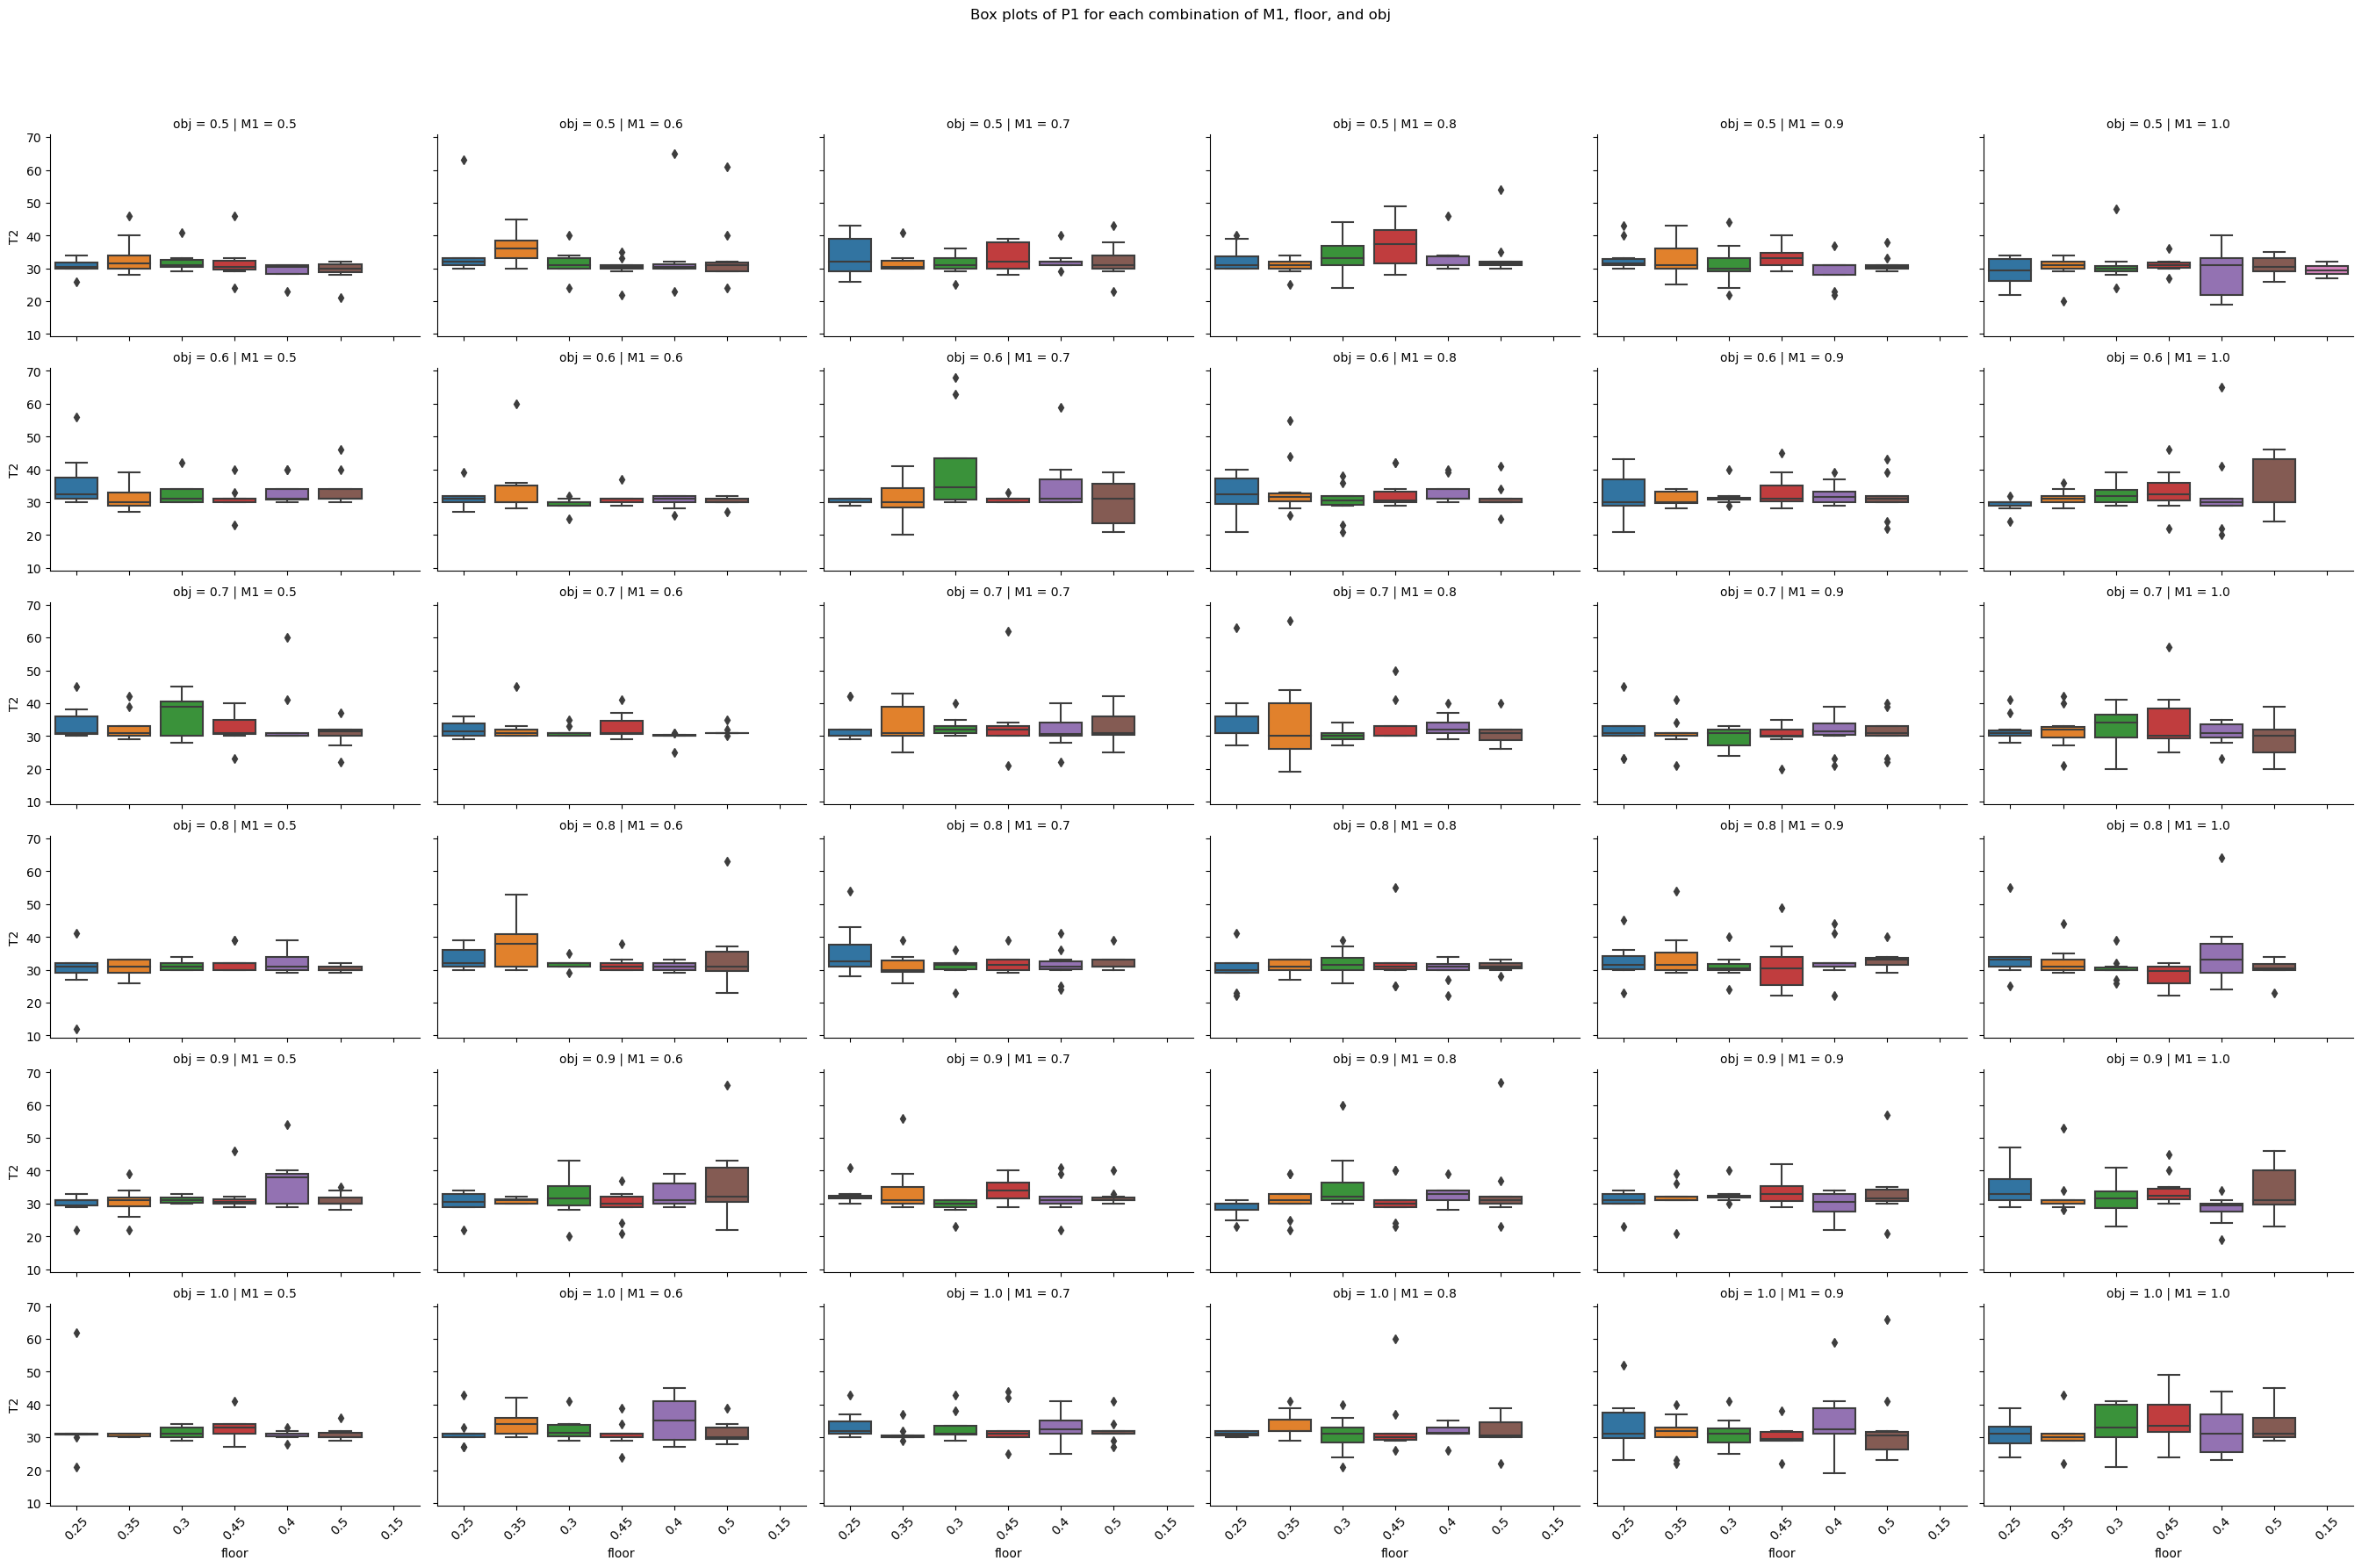

smoothoutcome  number of files:  217
Last data file: smoothoutcome_1.0_0.5_1.0.csv


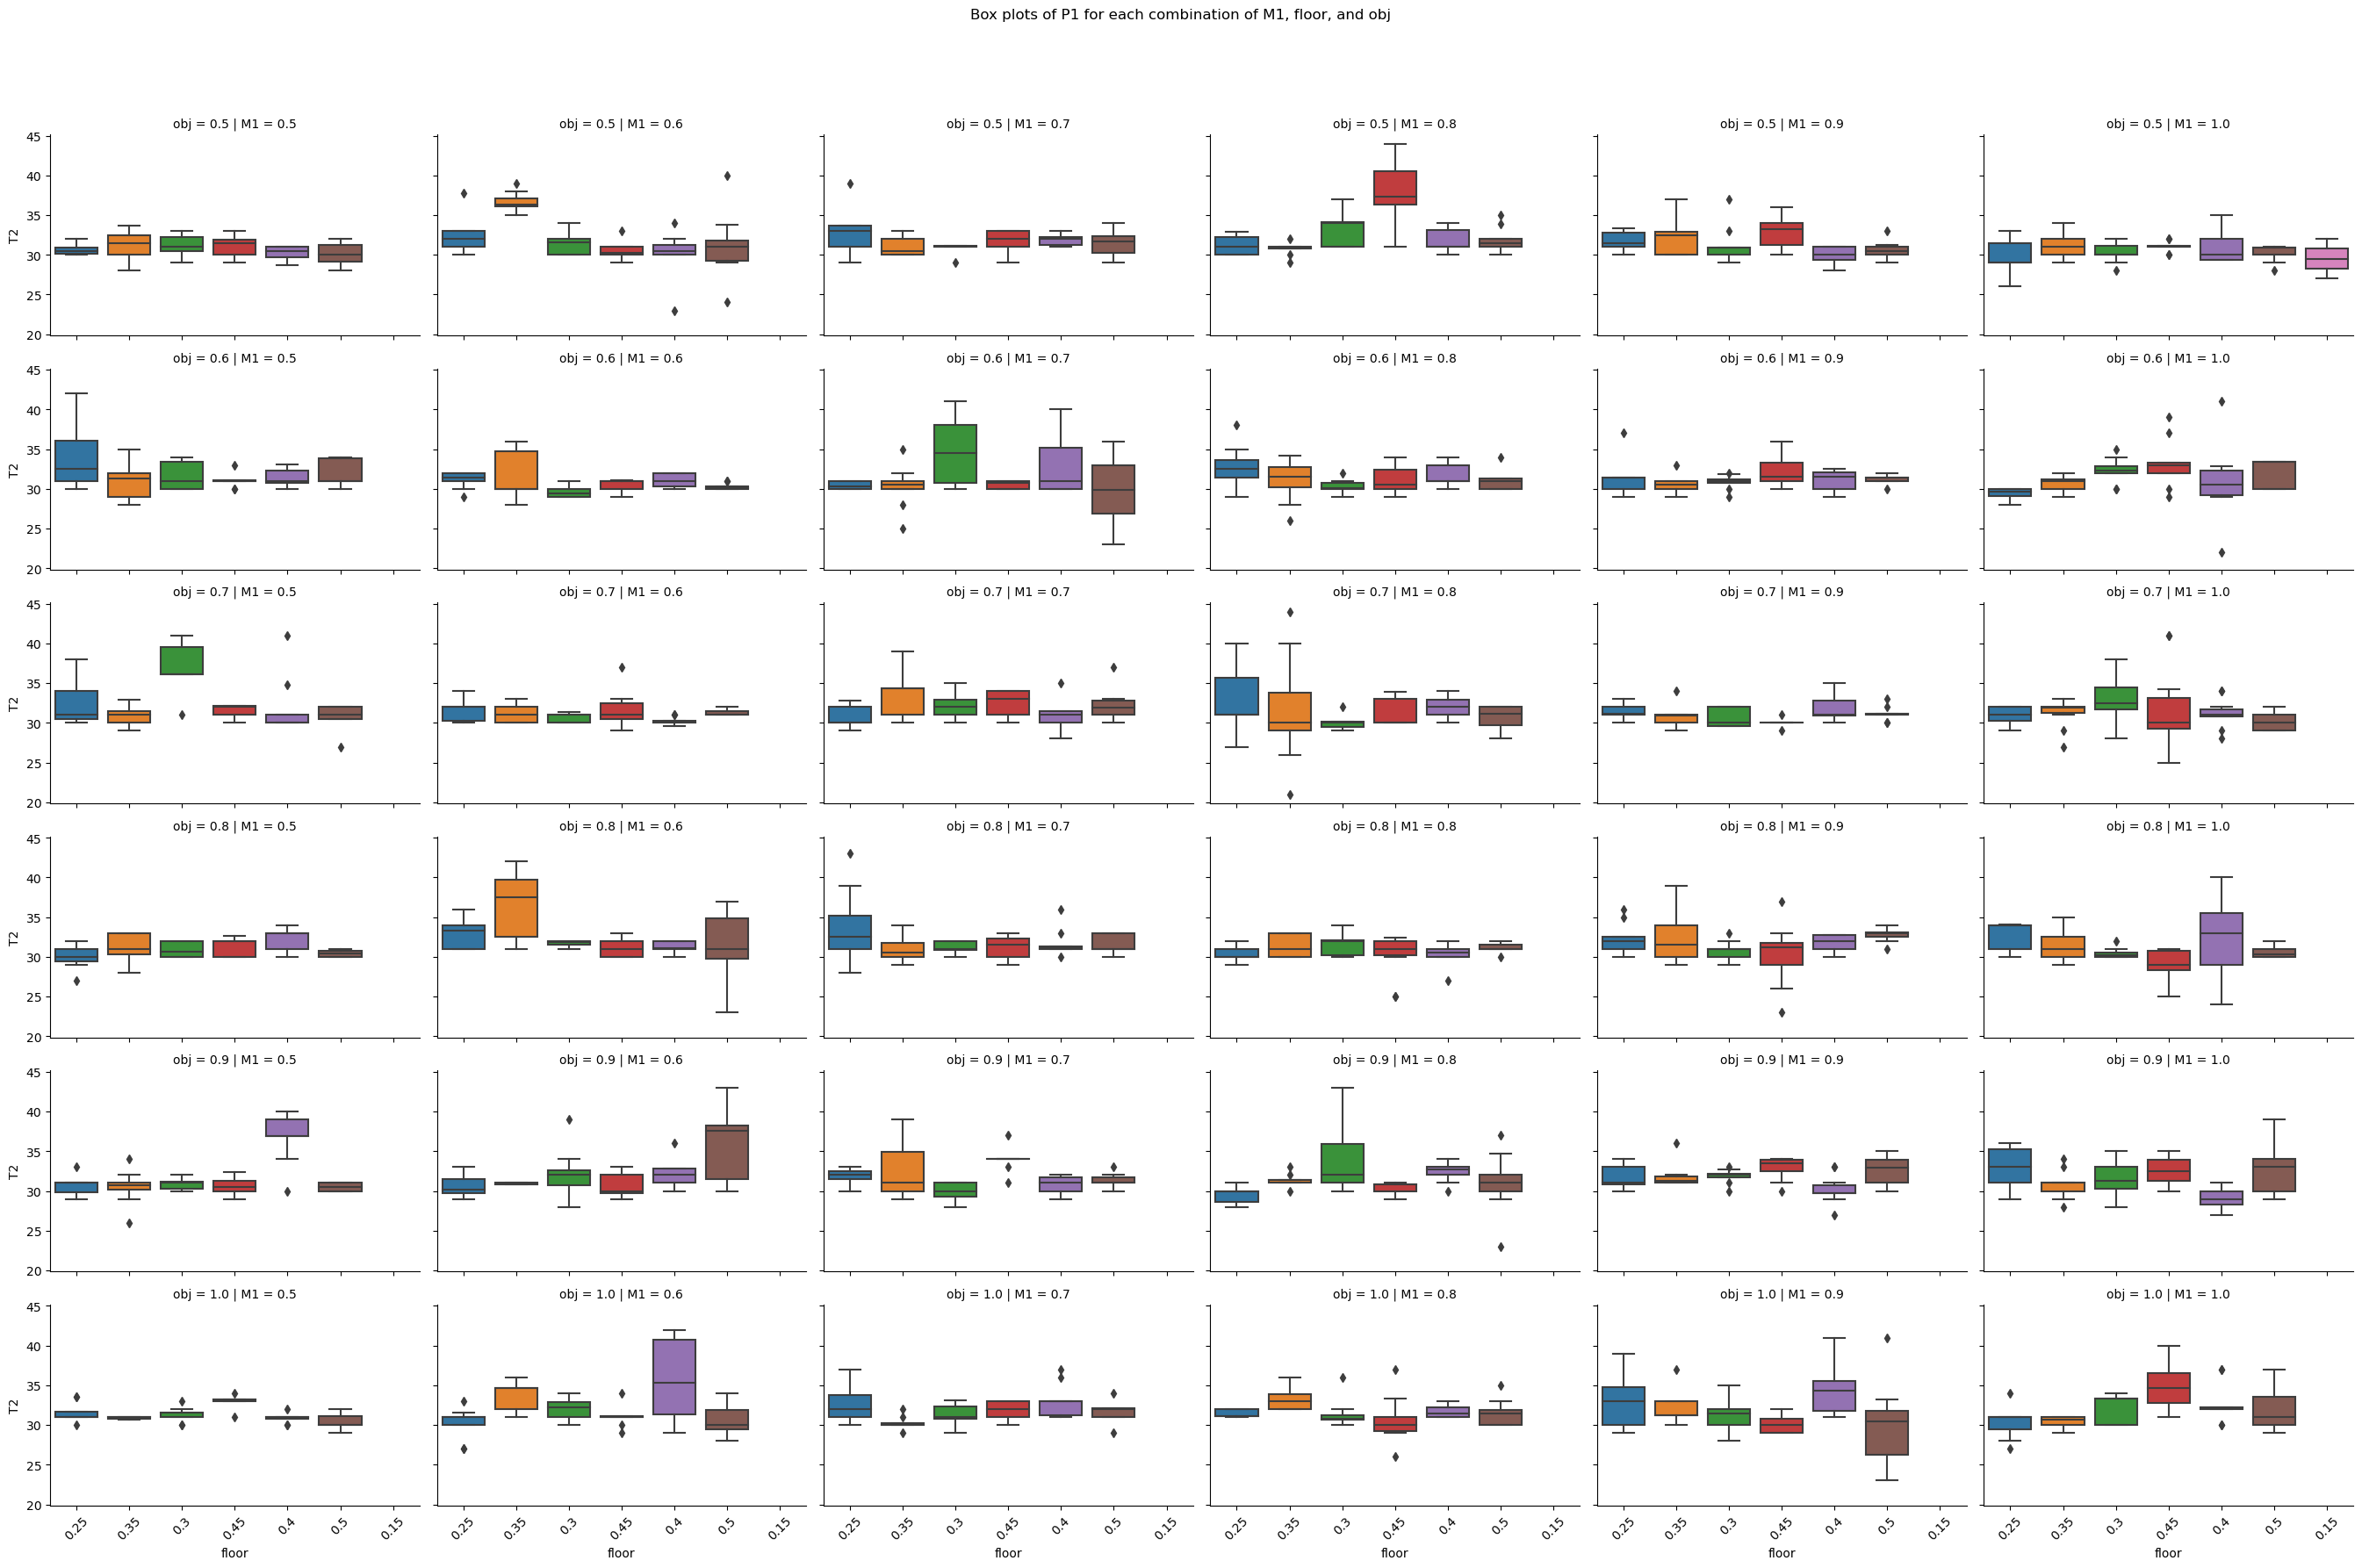

In [26]:
def main():
    
    csv_folder = "Data/Lookup tables/Raw data/csv_files" # raw data
    #hist_file = "Data/Historical logs/day.csv"           # one day run
    
    #----Smooth data
    # Uses Winsorize algorithm.
    # Outliers are considered to be outside n standard dev.
    # Replacement of outliers is done using the values of +-n standard dev.
    #If n<0,
    # Outliers are considered to be outside |n| standard dev.
    # Replacement of outliers with the mean.
    std = -1
    smoothRawData(csv_folder,"T2,T2F,TR,T3",std,"false")        # T1 and T1F not considered anymore
    
    #Compare plotting data
    checkFor = "T2"
    # - raw data
    csv_name = "outcome"
    df = combineM1M2M3(csv_folder,csv_name)
    plotFacetGridBox(df,checkFor)
    
    # - smoothed
    csv_name = "smoothoutcome"
    dfsmooth = combineM1M2M3(csv_folder,csv_name)
    plotFacetGridBox(dfsmooth,checkFor)
    
    
if __name__ == "__main__":
    main()
    
    

#### Notice that there still variability in the values of T2. For a combination of M1,M2,M3 (i.e., M1, floor, obj), the ideal is to have a single value, so that we assume that knowing M1,M2,M3 will always translate into a deterministic value of T2.

#### We make the assumption that this is the case: "The values of all times, Ti's, are fixed for any M1,M2,M3"

# Read p1,p2,...,T1,T2,... for each combinations of M1-M3

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
#Previously in C code
def get_line(line):
    return line

def get_val(sum_val, count):
    return sum_val / count if count != 0 else -1

def print_val(val, label):
    if val > -1:
        print(f"{label}: {val}")
    else:
        print(f"{label}: No recorded data.")

def print_val_to_file(output_file, val):
    if val > -1:
        output_file.write(f"{val:.2f},")
    else:
        output_file.write(f"NoData,")

def print_enter_to_file(output_file):
    output_file.write("\n")

def print_val_to_filename(output_file, filename):
    output_file.write(f"file:{filename},,")




def get_field(ttype,line,num):
    if(ttype==int):
        return int(float(line[num-1]))
    if ttype==float:
        return float(line[num-1])

def get_data(filename,outputFile):
    # Running totals and counts
    p1_count = p1_sum = T1_count = T1_sum = T1F_count = T1F_sum = 0
    p2_sum = p3_sum = grab_attempts = T2_count = T2_sum = TR_count = TR_sum = T2F_count = T2F_sum = 0
    p4_count = p4_sum = T3_count = T3_sum = 0

    with open(filename, 'r') as stream:
        stream.readline()  # Discard first line that contains field names
        for line in stream:
            
            line = line.strip().split(',')
            
            p1_check = get_field(int,line,5)
            p1_count += 1
            if p1_check == 1:
                p1_sum += 1
                T1_count += 1
                T1_sum += get_field(float,line,6)
                p2_check = get_field(int,line,8)
                if p2_check == 1:
                    p2_sum += 1
                    grab_attempts += 1
                    T2_count += 1
                    T2_sum += get_field(float,line,9)
                    p4_count += 1
                    if get_field(int,line,50) == 1:
                        p4_sum += 1
                    T3_count += 1
                    T3_sum += get_field(float,line,51)
                elif get_field(int,line,9) > -1:
                    grab_attempts += 1
                    T2_count += 1
                    T2_sum += get_field(float,line,10)
                for i in range(10, 29):
                    if get_field(int,line,i) > -1:
                        p3_sum += 1
                        grab_attempts += 1
                        T2F_count += 1
                        T2F_sum += get_field(float,line,i)
                    else:
                        break
                for i in range(30, 49):
                    if get_field(int,line,i) > -1:
                        TR_count += 1
                        TR_sum += get_field(float,line,i)
                    else:
                        break
            else:
                T1F_count += 1
                T1F_sum += get_field(float,line,7)

    # Calculate values
    p1 = get_val(p1_sum, p1_count)
    T1 = get_val(T1_sum, T1_count)
    T1F = get_val(T1F_sum, T1F_count)
    p2 = get_val(p2_sum, grab_attempts)
    p3 = get_val(p3_sum, grab_attempts)
    T2 = get_val(T2_sum, T2_count)
    TR = get_val(TR_sum, TR_count)
    T2F = get_val(T2F_sum, T2F_count)
    p4 = get_val(p4_sum, p4_count)
    T3 = get_val(T3_sum, T3_count)

    # Print to terminal
    #print(f"Fileeeee: {filename}")
    expected_path = "Data/Lookup tables/Raw data/csv_files/outcome_0.5_0.25_0.5.csv"
    if filename == expected_path:
        print("Paths match!")
        print_val(p1, "p1")
        print_val(T1, "T1")
        print_val(T1F, "T1F")
        print_val(p2, "p2")
        print_val(p3, "p3")
        print_val(T2, "T2")
        print_val(TR, "TR")
        print_val(T2F, "T2F")
        print_val(p4, "p4")
        print_val(T3, "T3")
        
    
    m = filename.split("outcome")[1].replace(".csv","").split("_")
    m1=float(m[1]); m2=float(m[2]);  m3=float(m[3])
    # Write to output file
    with open(outputFile, "a") as output_file:
        #print_val_to_filename(output_file, filename)
        print_val_to_file(output_file, m1)
        print_val_to_file(output_file, m2)
        print_val_to_file(output_file, m3)
        print_val_to_file(output_file, p1)
        print_val_to_file(output_file, T1)
        print_val_to_file(output_file, T1F)
        print_val_to_file(output_file, p2)
        print_val_to_file(output_file, p3)
        print_val_to_file(output_file, T2)
        print_val_to_file(output_file, TR)
        print_val_to_file(output_file, T2F)
        print_val_to_file(output_file, p4)
        print_val_to_file(output_file, T3)
        print_enter_to_file(output_file)
        
def readRawData(folder_path,outputFile,start="smoothoutcome"):
    clean_file(outputFile)
    with open(outputFile, "a") as output_file:
        col = ", ".join(["M1","M2","M3","p1","T1","T1F","p2","p3","T2","TR","T2F","p4","T3","Pretry","violation"])+"\n"
        output_file.write(col)
    for filename in os.listdir(folder_path):
        full_path = get_full_path(folder_path, filename)
        if os.path.isfile(full_path) and (filename.split("_")[0]==start):
            #print(f"File: {filename}")
            get_data(full_path,outputFile)
    print("Saved in ",outputFile)

In [29]:
def main():
    csv_folder = "Data/Lookup tables/Raw data/csv_files" # raw data
    hist_file = "Data/Historical logs/day.csv"           # one day run
    
    #Read raw data and obtain p1,p2,p3...,T1,T2,... from M1-M3 from saved simulations
    startwith="smoothoutcome" # or "outcome" for unfiltered
    readRawData(csv_folder,"output.csv",startwith)

if __name__ == "__main__":
    main()


Saved in  output.csv


## Violation zone - Using Julie's fitted funtions

For reference, to obtain bounds of requirements,
```
R1 is very sentitive after 0.57
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.075# 0% violated
R1_bound = 0.58; R2_bound = 232; R3_bound = 0.075# 12.5 violated <-----
R1_bound = 0.59; R2_bound = 232; R3_bound = 0.075# 52.25 violated R1

R2 sensitive around 190-200
R1_bound = 0.57; R2_bound = 190; R3_bound = 0.075# 79.53% violated
R1_bound = 0.57; R2_bound = 200; R3_bound = 0.075# 22.46 violated <-----

R3 very sensitive 0% to 80% in 0.099 change
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.1  # 0% violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.05 # 11% violated <-----
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.045# 20 violated 
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.04 # 25 violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.02 # 50 violated
R1_bound = 0.57; R2_bound = 232; R3_bound = 0.001# 80 violated

R1_bound = 0.58; R2_bound = 200; R3_bound = 0.045# 45.18% violated
R1_bound = 0.58; R2_bound = 200; R3_bound = 0.05 # 40.625% violated <----- This was selected
```

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt
from scipy.optimize import least_squares

#from patsy import dmatrices
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import statsmodels.stats.stattools as st

def insertCol(df):
    # Insert an empty columns
    df.insert(len(df.columns), 'R1', '')
    df.insert(len(df.columns), 'R2', '')
    df.insert(len(df.columns), 'R3', '')
    df.insert(len(df.columns), 'r1', '')
    df.insert(len(df.columns), 'r2', '')
    df.insert(len(df.columns), 'r3', '')
    df.insert(len(df.columns), 'V', '')
    return df


def checkViolation(p1,p2,p3,p4,T1,T1F,T2,T2F,TR,T3,Pretry):
    violation = 0
    r1,r2,r3 =0,0,0
    # compute R1-R3
    R1= (p1*p2*p4)/(1-Pretry*p3)
    R2= -1*(p1*(p3*T2-p2*T3-p3*T2F-T1-T2+T1F)+Pretry*p3*(T1F-p1*TR-p1*T1F)-T1F) / (1-Pretry*p3)
    R3 = (p1*p2*(1-p4))/(1-Pretry*p3)
    # check violation   (i.e., does not comply with innequalities, hence innequality symbols are flipped)
    if R1 <= R1_bound:  violation = 1; r1=1
    if R2 >= R2_bound:  violation = 1; r2=1
    if R3 >= R3_bound:  violation = 1; r3=1
    return [R1,R2,R3,r1,r2,r3,violation]


def addViolationValues(df):
    for index,row in df.iterrows():
        M1 = row['M1']; M2= row['M2']; M3 = row['M3']
        x = row['M3'] #dummy
        #check violation
        [R1,R2,R3,r1,r2,r3,violation] = checkViolation(p1(M1),p2(M1,M3),p3(M1,M3),p4(M3),T1(M1,M2),
                                                       T1F(M2),T2(x),T2F(x),TR(M1,M3),T3(M2),pR(x))
        df.loc[index,'p1'],df.loc[index,'p2'], df.loc[index,'p3'],df.loc[index,'p4'], df.loc[index,'T1'],df.loc[index,'T1F'],df.loc[index,'T2'],df.loc[index,'T2F'],df.loc[index,'TR'],df.loc[index,'T3'], df.loc[index,'Pretry']=p1(M1),p2(M1,M3),p3(M1,M3),p4(M3),T1(M1,M2), T1F(M2),T2(x),T2F(x),TR(M1,M3),T3(M2),pR(x)
        df.loc[index,'R1'],df.loc[index,'R2'],df.loc[index,'R3'] = R1,R2,R3
        df.loc[index,'r1'],df.loc[index,'r2'],df.loc[index,'r3'] = r1,r2,r3
        df.loc[index,'V'] = violation
    
    df.to_csv('_LookUpTableViolation.csv', index=False)
    df.head(20)
    return df

def print_results_violation(df):
    # Sum the values in the 'Age' column
    total_violation = df['V'].sum()
    total = len(df['V'])
    print(" Total data points: {}.\n Total data points in violation: {}.\n Percentage in violation: {}%."
          .format(total,total_violation,total_violation/total*100))

def read_Day_csv(hist_file):
    dfM = pd.read_csv(hist_file)
    dfM.columns=["Time","M1","M2","M3","state"]
    #dfM = insertCol(dfM)
    return dfM


def plot_M_violation(df,title):
    fig, ax1 = plt.subplots()
    #
    ax1.plot(df["Time"], df["M1"], color='b', label='M1')
    ax1.set_xlabel('Time'); ax1.set_ylabel('M1', color='b'); ax1.tick_params('y', colors='b')
    #
    ax2 = ax1.twinx()
    ax2.plot(df["Time"], df["M2"], color='r', label='M2'); ax2.set_ylabel('M2', color='r'); ax2.tick_params('y', colors='r')
    #
    ax3 = ax1.twinx();ax3.spines['right'].set_position(('outward', 60))  # Adjust the position of the third y-axis
    ax3.plot(df["Time"], df["M3"], color='g', label='M3'); ax3.set_ylabel('M3', color='g'); ax3.tick_params('y', colors='g')
    #
    ax4 = ax1.twinx();ax4.spines['right'].set_position(('outward', 110))  # Adjust the position of the third y-axis
    ax4.plot(df["Time"], df["V"], color='y', label='M1'); ax4.set_ylabel('V', color='y'); ax4.tick_params('y', colors='y')
    # Adding legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax3.legend(lines + lines2 + lines3+ lines4, labels + labels2 + labels3+ labels4, loc='upper right')
    #
    plt.title(title)
    plt.show()


def get_Window_vals(index1, index2, col, df):
    vals = df.loc[index1:index2, col].tolist()
    return vals

def _smooth_moving_avr_col(df,col,N):

    dfOriginal = df.copy()
    
    for index,row in df.iterrows():
        if(index<=N and index!=0): #first N, average
            _vals = get_Window_vals(0,index,col,dfOriginal)
            avr = sum(_vals)/len(_vals)
            df.loc[index,col] = avr
            
        if(index>N):
            _vals = get_Window_vals(index-N,index,col,dfOriginal)
            avr = sum(_vals)/len(_vals)
            df.loc[index,col] = avr
    return df
            
def smooth(df,cols,N):
    for col in cols:
        df = _smooth_moving_avr_col(df,col,N)
    return df

        

 Total data points: 3084.
 Total data points in violation: 1357.0.
 Percentage in violation: 44.001297016861216%.


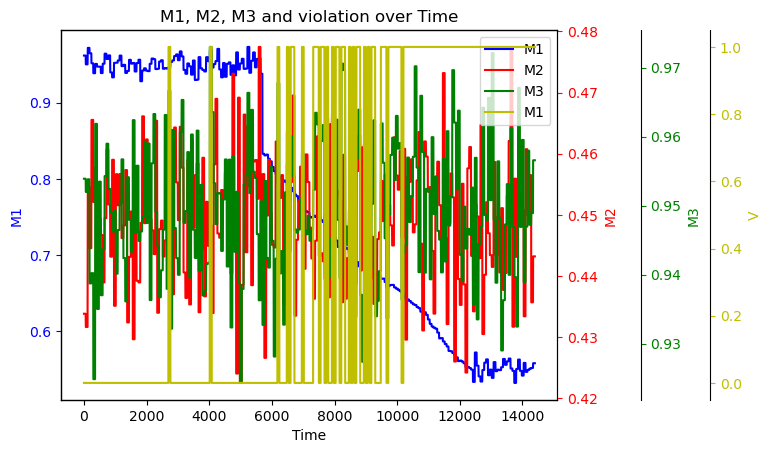

 Total data points: 3084.
 Total data points in violation: 877.0.
 Percentage in violation: 28.437094682230867%.


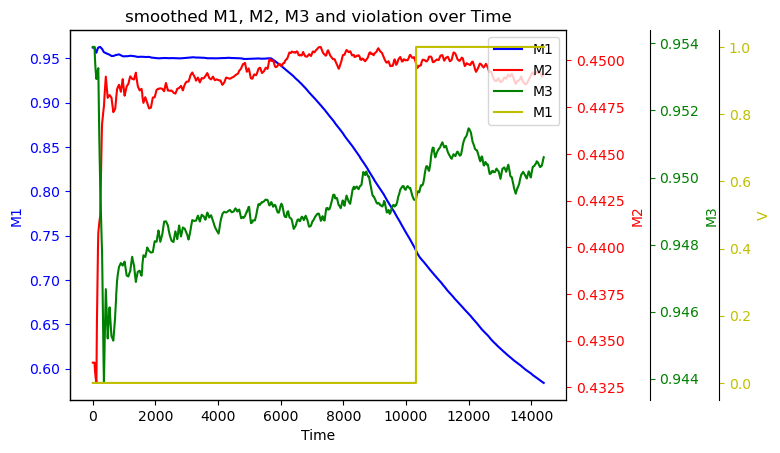

In [31]:
#============ SET UP PROBLEM
# Req. bounds
R1_bound = 0.58; R2_bound = 200; R3_bound = 0.05 # 40.625% violated
#M1 value
minM1=0.5; maxM1= 1; M =20
#M2
minM2=0.25; maxM2=0.5; smoothN=20
#M3
minM3=0.5; maxM3=1; L=20
#fun
p1 =lambda M1   : M1*0.0381941 + 0.962500
p2 = lambda M1,M3: 0.65301 + 0.05833 * M1 - 0.11750 * M3 - 0.04865 * M1 * M3       # before only M3
p3 = lambda M1,M3: 0.16218 - 0.04194 * M1 - 0.01444 * M3 - 0.04167 * M1 * M3       # before only M1
p4 = lambda M3   : 0.80629 + 0.21175 * M3
pR = lambda x : 0.6
T1 = lambda M1,M2: 134.171 - 11.929 * M1 - 7.999 * M2     
T2 = lambda M3 : 25.3942 - 5.0085 * M3
T3 = lambda M2: 53.7                          
T1F= lambda M2: 349.772 - 10.97 * M2                                               # fixed before
T2F= lambda x :59.1 
TR = lambda M1,M3: 52.8953 - (0.2339 *M1) + (8.5904 *M3) + (15.6654 * M1 * M3)     # before M
#file
hist_file = "Data/Historical logs/day_faulty_light.csv"           # one day run

#============= SET UP SMOOTH
inf = float('inf')
smoothN = 1000 # update threshold: capacity of buffer (initially empty) used to store the last N observations - triggers an update of the linear regression model 
t = 2000 # prediction window within which any disruptions are to be predicted
violationTime = [inf,inf,inf]


#=============== RUN
df= read_Day_csv(hist_file)
df = addViolationValues(df)
print_results_violation(df)
plot_M_violation(df,'M1, M2, M3 and violation over Time')

dfSmooth = read_Day_csv(hist_file)
dfSmooth=smooth(dfSmooth,["M1","M2","M3"],smoothN)
dfSmooth = addViolationValues(dfSmooth)
print_results_violation(dfSmooth)
plot_M_violation(dfSmooth,"smoothed M1, M2, M3 and violation over Time")

In [32]:
df.columns

Index(['Time', 'M1', 'M2', 'M3', 'state', 'p1', 'p2', 'p3', 'p4', 'T1', 'T1F',
       'T2', 'T2F', 'TR', 'T3', 'Pretry', 'R1', 'R2', 'R3', 'r1', 'r2', 'r3',
       'V'],
      dtype='object')

### Predicting disruptions using ARIMA

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
def get_predictions(df,col='M1',tWindow=1000):
    '''
    df = dataframe
    tWindow= number of steps in the future you want to forecast
    col = name of the column in df to make predictions
    '''
    #M1 
    arima_model = auto_arima(df[col], seasonal=False, trace=True)
    print(arima_model.summary())

    # Get the ARIMA parameters
    p, d, q = arima_model.order

    # Fit ARIMA model
    model = ARIMA(df[col], order=(p, d, q))
    fitted_model = model.fit()

    # Forecast future values
    forecast = fitted_model.forecast(steps=tWindow)
    print(forecast)

    # Series to df
    s = pd.Series(forecast.values, index=forecast.index, name=col)
    dfPred = s.to_frame()
    return dfPred


In [ ]:
plt.plot(df.index,df.M1)
plt.plot(dfPred.index,forecast)

In [42]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

df = dfSmooth

# train is the window of past observations
#test is the future time window for prediciting Mi
train_data = df[(df['Time'] > 0) & (df['Time'] <= 1000)]
test_data = df[(df['Time'] > 1000)]

# select column to predict
col = "M1"
train_arima = train_data[col]
test_arima = test_data[col]

print(test_arima)

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)

future = [x for x in test_arima]
history.append(future)

# net_df = pd.read_csv("Netflix_stock_history.csv", index_col="Date", parse_dates=True)
# net_df.head(3)
train_data

216     0.952219
217     0.952221
218     0.952222
219     0.952224
220     0.952226
          ...   
3079    0.584254
3080    0.584152
3081    0.584051
3082    0.583950
3083    0.583848
Name: M1, Length: 2868, dtype: float64


/Users/grisv/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Time,M1,M2,M3,state,p1,p2,p3,p4,T1,...,TR,T3,Pretry,R1,R2,R3,r1,r2,r3,V
1,5,0.962056,0.433821,0.953896,0,0.999245,0.552398,0.069817,1.008278,119.224506,...,75.240784,53.7,0.6,0.580883,183.132076,-0.004769,0.0,0.0,0.0,0.0
2,10,0.962056,0.433821,0.953896,0,0.999245,0.552398,0.069817,1.008278,119.224506,...,75.240784,53.7,0.6,0.580883,183.132076,-0.004769,0.0,0.0,0.0,0.0
3,15,0.962056,0.433821,0.953896,0,0.999245,0.552398,0.069817,1.008278,119.224506,...,75.240784,53.7,0.6,0.580883,183.132076,-0.004769,0.0,0.0,0.0,0.0
4,20,0.962056,0.433821,0.953896,0,0.999245,0.552398,0.069817,1.008278,119.224506,...,75.240784,53.7,0.6,0.580883,183.132076,-0.004769,0.0,0.0,0.0,0.0
5,25,0.962056,0.433821,0.953896,0,0.999245,0.552398,0.069817,1.008278,119.224506,...,75.240784,53.7,0.6,0.580883,183.132076,-0.004769,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,985,0.952213,0.448540,0.947434,1,0.998869,0.553339,0.070970,1.006909,119.224184,...,74.944086,53.7,0.6,0.581284,183.496241,-0.003989,0.0,0.0,0.0,0.0
212,990,0.952214,0.448477,0.947442,1,0.998869,0.553338,0.070970,1.006911,119.224671,...,74.944306,53.7,0.6,0.581284,183.496518,-0.003990,0.0,0.0,0.0,0.0
213,995,0.952215,0.448415,0.947451,1,0.998869,0.553336,0.070969,1.006913,119.225154,...,74.944524,53.7,0.6,0.581283,183.496792,-0.003991,0.0,0.0,0.0,0.0
214,995,0.952217,0.448353,0.947459,7,0.998869,0.553335,0.070969,1.006914,119.225633,...,74.944740,53.7,0.6,0.581283,183.497064,-0.003992,0.0,0.0,0.0,0.0


In [43]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

ValueError: Found input variables with inconsistent numbers of samples: [2868, 1]

In [ ]:
#==== Trying other Ns
smoothN = 100

dfSmooth = read_Day_csv(hist_file)
dfSmooth=smooth(dfSmooth,["M1","M2","M3"],smoothN)
dfSmooth = addViolationValues(dfSmooth)
print_results_violation(dfSmooth)
plot_M_violation(dfSmooth,"smoothed M1, M2, M3 and violation over Time")

In [ ]:
d=get_rows(2178, len(dfSmooth), dfSmooth)
d=d[d.V==1]
d = d[d.Time==d.Time.min()]
if len(d)==1:
    time=d.Time.tolist()[0]
time

NameError: name 'get_rows' is not defined

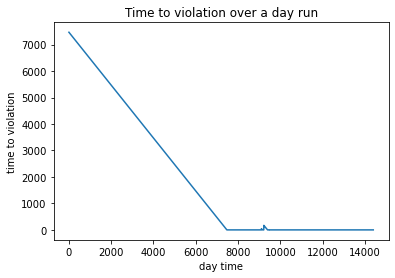

In [ ]:
def get_rows(index1, index2, df):
    df_vals = df[index1:index2]
    return df_vals

def get_time_to_viol(index,dfSmooth):
    d=get_rows(index, len(dfSmooth), dfSmooth)
    d=d[d.V==1]
    d = d[d.Time==d.Time.min()]
    if len(d)==1:
        time_next_violation=d.Time.tolist()[0]
        t0 = dfSmooth.iloc[index]["Time"]
        tv = time_next_violation-t0
        return tv
    return -1 #inf

def get_time_to_viol_GroundTruth(dfSmooth):
    #Time to violation
    time = ["Time","T_v","Tpred_v"]
    df_time= pd.DataFrame(columns=time)
    df_time["Time"] = dfSmooth["Time"]
    #====time to violation
    for i in range(0,len(dfSmooth)):
        df_time.loc[i,"T_v"] = get_time_to_viol(i,dfSmooth)

plt.plot(df_time["Time"],df_time["T_v"])
plt.ylabel("time to violation")
plt.xlabel("day time")

plt.title("Time to violation over a day run")
plt.show()

# TESTING ------
Not part of the final code yet

 Total data points: 3084.
 Total data points in violation: 1429.0.
 Percentage in violation: 46.335927367055774%.


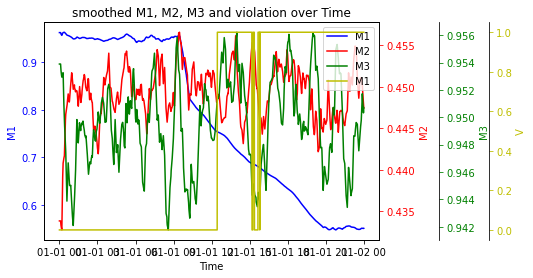

In [ ]:
def min2time(dfSmooth):
    '''Scale to minutes (1440 min in 24hrs)'''
    dfSmooth['Time']=dfSmooth['Time']/10
    dfSmooth['Time'] = dt.datetime(2024,1,1) + pd.TimedeltaIndex(dfSmooth['Time'], unit='m')
    return dfSmooth

def time2min(df,col="ds"):
    # subtract Datetime from epoch datetime
    df[col] = df[col] - dt.datetime(2024,1,1)
    #df[col] = df[col].

    df[col] = pd.to_timedelta(df[col].astype(str)).dt.total_seconds()%60*10
    return df

dfSmooth = read_Day_csv(hist_file)

dfSmooth = min2time(dfSmooth)

dfSmooth=smooth(dfSmooth,["M1","M2","M3"],smoothN)
dfSmooth = addViolationValues(dfSmooth)
print_results_violation(dfSmooth)
plot_M_violation(dfSmooth,"smoothed M1, M2, M3 and violation over Time")

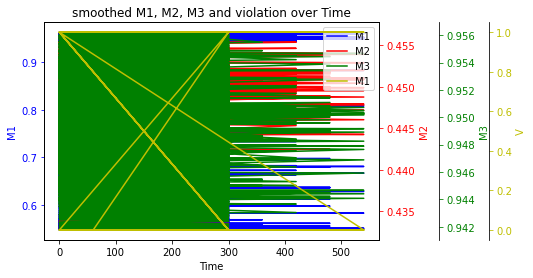

In [ ]:
plot_M_violation(time2min(dfSmooth,"Time"),"smoothed M1, M2, M3 and violation over Time")pip install patsy 

SyntaxError: invalid syntax (3130513587.py, line 2)

In [ ]:
# Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.
#fit() function takes a DataFrame of time series data
#ataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.
from prophet import Prophet
from pandas import to_datetime


#Get historical from time window N

def get_Window_vals(index1, index2, col, df):
    vals = df.loc[index1:index2, col].tolist()
    return vals

def fit_model(df,col,index,N):
    # time stamped data
    vals = get_Window_vals(index-N,index,col,df)
    time = get_Window_vals(index-N,index,"Time",df)
    df_time = pd.DataFrame.from_dict({'ds':time, 'y':vals})
    # time format
    df_time['ds']= to_datetime(df_time['ds'], unit='minute')
    # define the model
    model = Prophet()
    # fit the model
    model.fit(df_time)
    return model

def fitted(df,N,t_current):
    models={}
    
    dfOriginal = df.copy()
    index = N+t_current #current time
    # time window data
    col="M1"

    model = fit_model(dfOriginal,col,index,N)
    models[col]=model
    print(models)
    return models

def futureWindow(df,t,t_current):
    future = get_Window_vals(t_current,t_current+t,"Time",df)
    return pd.DataFrame.from_dict({'ds':future})

smoothN=1000
t = 1000 # prediction window within which any disruptions are to be predicted

t_current = 2000

m=fitted(dfSmooth,smoothN,t_current)

future = futureWindow(dfSmooth,t,t_current)

forecast = m["M1"].predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


In [ ]:
#fig1 = m["M1"].plot(forecast)

x=forecast[['ds']]
y=forecast[['yhat']]

plt.plot(x,y)
plt.show()

In [ ]:


# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

In [ ]:
print(smoothN,t)

df = dfSmooth.copy()



### Set up

In [ ]:
#sudo pip install fbprophet
# check prophet version

import prophet
# print version number
print('Prophet %s' % prophet.__version__)



# 2 Get time to boundary

#### 1 Read last N data measurements M1-M3 of robot performance (in a day of work)
#### 2 Stimate past from this data
#### 3 Calculate time to boundary
#### 4 Calculate "real time to boundary" (aka, read future M1-M3 and see if enter violation)
**Check also if out of operational domain**

In [ ]:
df2 = df.copy()

df2 = df2[["Time","M1"]]

df2

In [ ]:
from statsmodel.graphics.tsaplots import plot_acf

ModuleNotFoundError: No module named 'statsmodel'